In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, brier_score_loss
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('hmda_2017_nationwide_all-records_labels.csv')

/var/folders/zq/8l_n9qqn4n5g7gy6qss74dl00000gn/T/ipykernel_91268/4080357730.py:1: DtypeWarning: Columns (34,36,38,44,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('hmda_2017_nationwide_all-records_labels.csv')


In [ ]:
data = data[data["state_abbr"] == "MA"]


In [6]:
print(len(data))
data.head()

282546


,as_of_year,respondent_id,agency_name,agency_abbr,agency_code,loan_type_name,loan_type,property_type_name,property_type,loan_purpose_name,...,edit_status_name,edit_status,sequence_number,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,application_date_indicator
33,2017,0000066364,National Credit Union Administration,NCUA,5,Conventional,1,One-to-four family dwelling (other than manufa...,1,Home purchase,...,NaN,NaN,NaN,5546.0,7.100000,104800.0,104.790001,1675.0,2227.0,NaN
97,2017,0000026336,Federal Deposit Insurance Corporation,FDIC,3,Conventional,1,One-to-four family dwelling (other than manufa...,1,Home purchase,...,NaN,NaN,NaN,4755.0,27.440001,104800.0,133.389999,1352.0,1949.0,NaN
121,2017,0000852218,Consumer Financial Protection Bureau,CFPB,9,Conventional,1,One-to-four family dwelling (other than manufa...,1,Home purchase,...,NaN,NaN,NaN,3587.0,17.840000,94300.0,204.970001,1071.0,1202.0,NaN
152,2017,0000704167,Office of the Comptroller of the Currency,OCC,1,Conventional,1,One-to-four family dwelling (other than manufa...,1,Refinancing,...,NaN,NaN,NaN,6147.0,12.120000,84000.0,94.489998,1224.0,1980.0,NaN
164,2017,54-1994393,Department of Housing and Urban Development,HUD,7,Conventional,1,One-to-four family dwelling (other than manufa...,1,Refinancing,...,NaN,NaN,NaN,6147.0,12.120000,84000.0,94.489998,1224.0,1980.0,NaN


In [7]:
data["approved"] = data["action_taken"].isin([1, 2]).astype(int)

def clean_str(s):
    return (str(s).strip().lower() if pd.notnull(s) else s)

for c in ["applicant_race_name_1", "applicant_ethnicity_name", "applicant_sex_name",
          "state_abbr", "loan_purpose_name", "property_type_name", "owner_occupancy_name"]:
    if c in data.columns:
        data[c] = data[c].map(clean_str)

drop_vals = set([
    "not applicable",
    "information not provided by applicant in mail, internet, or telephone application",
    "race not available",
    "not provided",
    "no co-applicant"
])

if "applicant_race_name_1" in data:
    data = data[~data["applicant_race_name_1"].isin(drop_vals)]
if "applicant_ethnicity_name" in data:
    data = data[~data["applicant_ethnicity_name"].isin(drop_vals)]
if "applicant_sex_name" in data:
    data = data[~data["applicant_sex_name"].isin(drop_vals)]

for num in ["loan_amount_000s", "applicant_income_000s", "minority_population",
            "hud_median_family_income", "tract_to_msamd_income",
            "number_of_owner_occupied_units", "number_of_1_to_4_family_units"]:
    if num in data.columns:
        data[num] = pd.to_numeric(data[num], errors="coerce")

data = data.dropna(subset=["approved"])  # must have outcome
data.shape


(218112, 79)

In [9]:
def disparate_impact(df, group_col, positive_col="approved", reference_value=None):
    g = df.groupby(group_col)[positive_col].mean().sort_values(ascending=False)
    if reference_value is None:
        reference_value = g.index[0]  # highest approval group as reference
    diratio = g / g.loc[reference_value]
    return g.to_frame("approval_rate").assign(DI_ratio=lambda x: x["approval_rate"]/x.loc[reference_value,"approval_rate"]), reference_value

# Race
race_table, race_ref = disparate_impact(data, "applicant_race_name_1")
# Sex
sex_table, sex_ref = disparate_impact(data, "applicant_sex_name")
# Ethnicity
eth_table, eth_ref = disparate_impact(data, "applicant_ethnicity_name")

print("Race disparate impact (ref =", race_ref, ")\n", race_table, "\n")
print("Sex disparate impact (ref =", sex_ref, ")\n", sex_table, "\n")
print("Ethnicity disparate impact (ref =", eth_ref, ")\n", eth_table, "\n")


Race disparate impact (ref = asian )
                                            approval_rate  DI_ratio
applicant_race_name_1                                             
asian                                           0.659452  1.000000
white                                           0.657500  0.997041
black or african american                       0.554277  0.840511
native hawaiian or other pacific islander       0.550000  0.834026
american indian or alaska native                0.515442  0.781622 

Sex disparate impact (ref = male )
                     approval_rate  DI_ratio
applicant_sex_name                         
male                     0.654230  1.000000
female                   0.645021  0.985924 

Ethnicity disparate impact (ref = not hispanic or latino )
                           approval_rate  DI_ratio
applicant_ethnicity_name                         
not hispanic or latino         0.654297  1.000000
hispanic or latino             0.606295  0.926636 



In [ ]:
df = data
df_sub = df.copy()
df_sub = df_sub[(df_sub["applicant_income_000s"]>0) & (df_sub["applicant_income_000s"].notna())]

df_sub["income_quintile"] = pd.qcut(df_sub["applicant_income_000s"], 5, labels=[1,2,3,4,5])

def approval_by_group_within_band(df, band_col, group_col, outcome="approved"):
    out = []
    for b, d in df.groupby(band_col):
        rates = d.groupby(group_col)[outcome].mean().sort_values(ascending=False)
        ref = rates.index[0]
        di = (rates / rates.loc[ref]).rename("DI_ratio")
        tmp = pd.concat([rates.rename("approval_rate"), di], axis=1)
        tmp[band_col] = b
        tmp["reference_group"] = ref
        out.append(tmp.reset_index())
    return pd.concat(out, ignore_index=True)

race_by_income = approval_by_group_within_band(df_sub, "income_quintile", "applicant_race_name_1")
sex_by_income  = approval_by_group_within_band(df_sub, "income_quintile", "applicant_sex_name")
eth_by_income  = approval_by_group_within_band(df_sub, "income_quintile", "applicant_ethnicity_name")

race_by_income.head(10)


,applicant_race_name_1,approval_rate,DI_ratio,income_quintile,reference_group
0,asian,0.582226,1.000000,1,asian
1,white,0.579527,0.995364,1,asian
2,black or african american,0.490529,0.842506,1,asian
3,native hawaiian or other pacific islander,0.487654,0.837569,1,asian
4,american indian or alaska native,0.437931,0.752167,1,asian
5,white,0.651270,1.000000,2,white
6,asian,0.647911,0.994843,2,white
7,black or african american,0.582224,0.893982,2,white
8,american indian or alaska native,0.549708,0.844055,2,white
9,native hawaiian or other pacific islander,0.527132,0.809391,2,white


In [ ]:
feats = []
cat_feats = []
num_feats = []

for c in ["loan_purpose_name", "property_type_name", "owner_occupancy_name", "state_abbr"]:
    if c in df.columns:
        feats.append(c); cat_feats.append(c)

for c in ["loan_amount_000s", "applicant_income_000s"]:
    if c in df.columns:
        feats.append(c); num_feats.append(c)

prot = []
if "applicant_race_name_1" in df: prot.append("applicant_race_name_1")
if "applicant_ethnicity_name" in df: prot.append("applicant_ethnicity_name")
if "applicant_sex_name" in df: prot.append("applicant_sex_name")

use_cols = feats + prot + ["approved"]
data = df.dropna(subset=use_cols).copy()

cat_all = cat_feats + prot
X_cat = pd.get_dummies(data[cat_all], drop_first=True)
X_num = data[num_feats]
X = pd.concat([X_num, X_cat], axis=1)
y = data["approved"]

X_sm = sm.add_constant(X, has_constant='add')
logit = sm.Logit(y, X_sm).fit(disp=0)
print(logit.summary())

odds_ratios = pd.Series(np.exp(logit.params), name="odds_ratio").sort_values(ascending=False)
odds_ratios.head(20)


                           Logit Regression Results                           
Dep. Variable:               approved   No. Observations:               212005
Model:                          Logit   Df Residuals:                   211991
Method:                           MLE   Df Model:                           13
Date:                Sat, 01 Nov 2025   Pseudo R-squ.:                 0.01836
Time:                        16:39:44   Log-Likelihood:            -1.3418e+05
converged:                       True   LL-Null:                   -1.3669e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                 

property_type_name_one-to-four family dwelling (other than manufactured housing)    2.886990
applicant_race_name_1_white                                                         1.589593
applicant_race_name_1_asian                                                         1.400929
loan_purpose_name_home purchase                                                     1.294663
applicant_ethnicity_name_not hispanic or latino                                     1.247828
applicant_race_name_1_native hawaiian or other pacific islander                     1.101348
applicant_race_name_1_black or african american                                     1.067312
applicant_sex_name_male                                                             1.015809
applicant_income_000s                                                               1.000718
loan_amount_000s                                                                    0.999952
loan_purpose_name_refinancing                                         

In [12]:
model_feats = feats  # exclude protected attrs to simulate "race-blind" model
df_ml = df.dropna(subset=model_feats + ["approved", "applicant_race_name_1"])
X = df_ml[model_feats]
y = df_ml["approved"]
groups = df_ml["applicant_race_name_1"].values

# Preprocess
numeric_features = [c for c in model_feats if c in num_feats]
categorical_features = [c for c in model_feats if c in cat_feats]

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features)
    ],
    remainder="drop"
)

clf = Pipeline(steps=[
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=1000))
])

X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(X, y, groups, test_size=0.3, stratify=y, random_state=42)

clf.fit(X_train, y_train)
proba = clf.predict_proba(X_test)[:,1]
yhat = (proba >= 0.5).astype(int)

auc = roc_auc_score(y_test, proba)
brier = brier_score_loss(y_test, proba)
print({"AUC": auc, "Brier": brier})

# Error rates by group
def rates(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        "TPR": tp / (tp + fn + 1e-9),
        "FPR": fp / (fp + tn + 1e-9),
        "FNR": fn / (fn + tp + 1e-9),
        "ACC": (tp+tn)/(tp+tn+fp+fn)
    }

rows = []
for grp in pd.Series(g_test).unique():
    idx = (g_test == grp)
    r = rates(y_test[idx], yhat[idx])
    r["group"] = grp
    r["n"] = idx.sum()
    r["selection_rate"] = yhat[idx].mean()
    rows.append(r)
err_by_group = pd.DataFrame(rows).set_index("group").sort_values("n", ascending=False)
err_by_group


{'AUC': 0.5961437509696214, 'Brier': 0.2210445940255171}


,TPR,FPR,FNR,ACC,n,selection_rate
group,,,,,,
white,1.0,1.0,0.0,0.661032,55073,1.0
asian,1.0,1.0,0.0,0.650247,4649,1.0
black or african american,1.0,1.0,0.0,0.568136,3471,1.0
american indian or alaska native,1.0,1.0,0.0,0.500000,260,1.0
native hawaiian or other pacific islander,1.0,1.0,0.0,0.550336,149,1.0


In [13]:
def calibration_table(y_true, p, group, bins=np.linspace(0,1,11)):
    out = []
    for g in pd.Series(group).unique():
        m = group==g
        b = pd.cut(p[m], bins, include_lowest=True)
        dfb = pd.DataFrame({"bin": b, "y": y_true[m]})
        tab = dfb.groupby("bin")["y"].mean().rename("actual_rate").reset_index()
        tab["pred_mid"] = tab["bin"].apply(lambda x: 0.5*(x.left+x.right))
        tab["group"] = g
        out.append(tab)
    return pd.concat(out, ignore_index=True)

cal = calibration_table(y_test.values, proba, g_test)
cal.head()


,bin,actual_rate,pred_mid,group
0,"(-0.001, 0.1]",NaN,0.0495,white
1,"(0.1, 0.2]",NaN,0.1500,white
2,"(0.2, 0.3]",NaN,0.2500,white
3,"(0.3, 0.4]",NaN,0.3500,white
4,"(0.4, 0.5]",NaN,0.4500,white


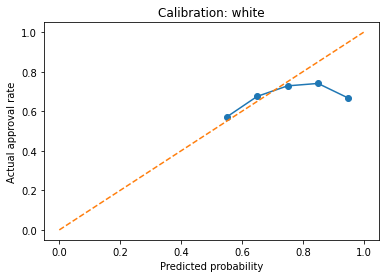

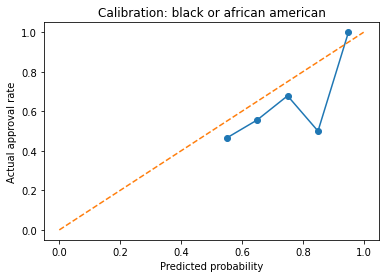

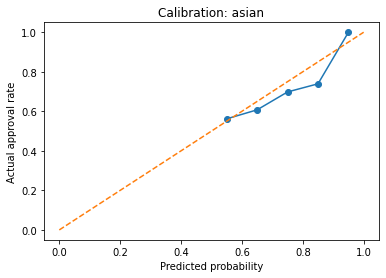

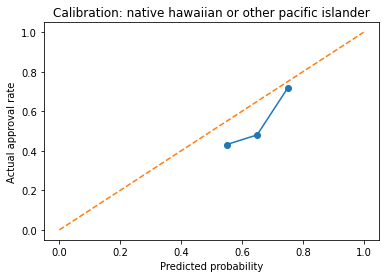

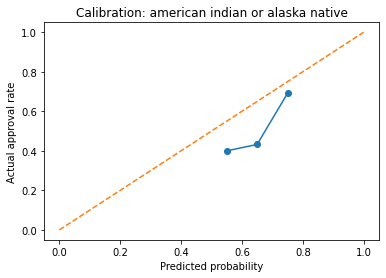

In [14]:
for g in cal["group"].unique():
    sub = cal[cal["group"]==g].sort_values("pred_mid")
    plt.figure()
    plt.plot(sub["pred_mid"], sub["actual_rate"], marker="o")
    plt.plot([0,1],[0,1], linestyle="--")  # reference line
    plt.title(f"Calibration: {g}")
    plt.xlabel("Predicted probability")
    plt.ylabel("Actual approval rate")
    plt.show()


33                                    NaN
97                                    NaN
121                                   NaN
164                  Debt-to-income ratio
265         Credit application incomplete
                        ...              
14112780                              NaN
14112804                              NaN
14112864                              NaN
14112867                              NaN
14113011                              NaN
Name: denial_reason_name_1, Length: 218112, dtype: object

In [ ]:
denied = df[df["action_taken"]==3].copy()
mix = (denied
        .groupby(["applicant_race_name_1","denial_reason_name_1"])
        .size()
        .rename("count")
        .reset_index())
# Share of each reason within a race
mix["share_within_race"] = mix.groupby("applicant_race_name_1")["count"].apply(lambda s: s/s.sum())
mix.sort_values(["applicant_race_name_1","share_within_race"], ascending=[True,False]).head(20)


,applicant_race_name_1,denial_reason_name_1,count,share_within_race
2,american indian or alaska native,Credit history,43,0.364407
3,american indian or alaska native,Debt-to-income ratio,38,0.322034
0,american indian or alaska native,Collateral,12,0.101695
1,american indian or alaska native,Credit application incomplete,9,0.076271
6,american indian or alaska native,Other,9,0.076271
5,american indian or alaska native,"Insufficient cash (downpayment, closing costs)",3,0.025424
4,american indian or alaska native,Employment history,2,0.016949
7,american indian or alaska native,Unverifiable information,2,0.016949
11,asian,Debt-to-income ratio,355,0.357143
8,asian,Collateral,193,0.194165


In [ ]:
summary_rows = []

# Disparate impact snapshots
for name, tab, ref in [
    ("race", race_table, race_ref),
    ("sex", sex_table, sex_ref),
    ("ethnicity", eth_table, eth_ref)
]:
    tmp = tab.copy()
    tmp["axis"] = name
    tmp["reference_group"] = ref
    summary_rows.append(tmp.reset_index().rename(columns={"index": "group"}))

di_summary = pd.concat(summary_rows, ignore_index=True)

# Error rate summary
err_summary = err_by_group.reset_index()

print("=== Disparate Impact Summary ===")
print(di_summary)

print("\n=== Error Rates by Group (Model) ===")
print(err_summary)


=== Disparate Impact Summary ===
                       applicant_race_name_1  approval_rate  DI_ratio  \
0                                      asian       0.659452  1.000000   
1                                      white       0.657500  0.997041   
2                  black or african american       0.554277  0.840511   
3  native hawaiian or other pacific islander       0.550000  0.834026   
4           american indian or alaska native       0.515442  0.781622   
5                                        NaN       0.654230  1.000000   
6                                        NaN       0.645021  0.985924   
7                                        NaN       0.654297  1.000000   
8                                        NaN       0.606295  0.926636   

        axis         reference_group applicant_sex_name  \
0       race                   asian                NaN   
1       race                   asian                NaN   
2       race                   asian                NaN   
